# Design and Implementation Choices

The chosen model has the following architecture:

- 1 Convolution Layer: 32 filters of 5x5, stride 1
- 1 Max Pooling Layer: 3x3 pool, stride 1
- 1 Convolution Layer: 32 filters of 5x5, stride 1
- 1 Max Pooling Layer: 2x2 pool, stride 2
- 1 Dense Layer: 1000 nodes, activation = ReLU 
- 1 Dropout Layer: 10% (0.1)
- 1 Output Layer: 5 nodes, activation = Softmax  

It contains the following hyperparameters:
- Loss: categorical crossentropy
- Optimizer: Adam
- Learning rate: step decay ($LR_i$ = 0.001, $DR$ = 0.6, $E_D$ = 9.0)
- Kernel Initializer: he_uniform
- Batch size: 64
- Epochs: 75

A simple, pictorial representation of the network architecture is shown below:

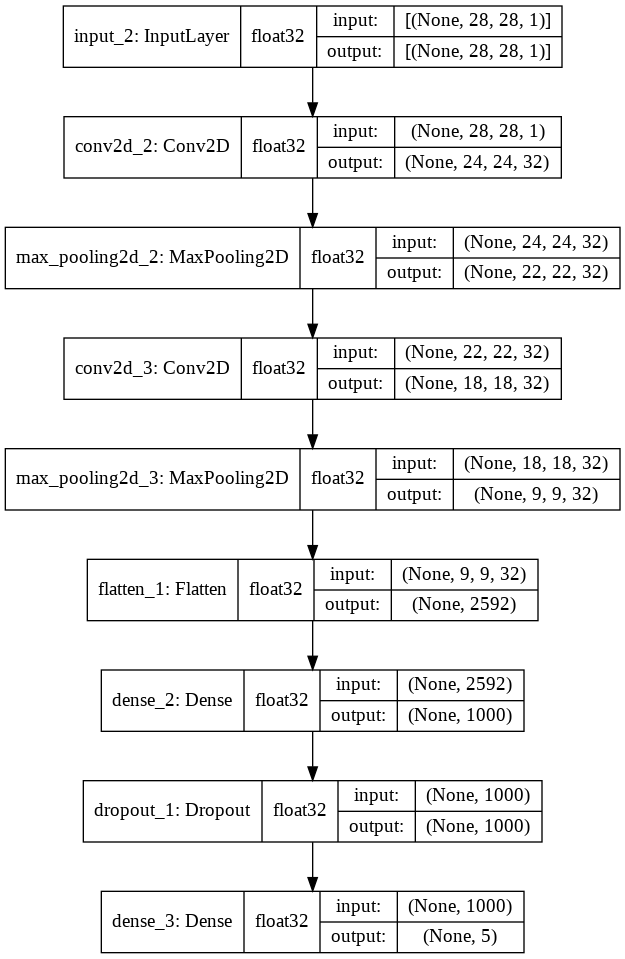

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)

# Critical Code Blocks 

In this section, the critical code block needed to implement our chosen model is shown here. Note that preprocessing is an important step in developing any model - this, along with a detailed walkthrough of how we arrived at our model permutation, can be seen in the **"Experimentation" section of Results Analysis**.

In [ ]:
from keras.callbacks import LearningRateScheduler
import math 

"""
We use a drop-based learning rate scheduler called setup decay.
This worked better for us than the original Adam decaying scheme.
These parameter values were achieved through experimentation.
"""
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

lrScheduler = LearningRateScheduler(step_decay)

"""
Here we create our model architecture. We build on top of the Keras 
Sequential model. The input layer is sized 28x28x1, which represents
pixel width x pixel height x number of channels - we use 1 for the
channels since all images are grayscale. The model has two convolution
layers: the convolutions are the same, with ReLu activation functions, 
32 filters sized 5x5, and a kernel initializer of he_uniform. The max
pooling layers differ in size and stride. The convolution portion becomes
flattened and connected to a dense layer of 1000 nodes. A dropout layer is
used to prevent overfitting. The output layer has 5 nodes with the softmax
activation function, since we have to classify an image from one of 5 labels.
"""
model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))

"""
Here we compile the model and use categorical cross entropy,
since this is a multi-class classification problem. We use the 
Adam optimizer for this model, and use a callback function 
to use our implementation of the step-decay learning rate.
"""
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam()
             )

"""
Here we train our model using a validation set. We have the following
split: training/validation/test == 60/20/20. We use a batch size of 64
and train for 75 epochs. As mentioned before, we use a callback function
to utiilize our custom step-decay learning rate.
"""
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, callbacks= lrScheduler,
                    epochs=75, shuffle=True)

"""
Here we test our model on the test set and output the test accuracy and 
test loss, rounded to the nearest three decimal places. We use verbose=1
to keep track of our training and testing progress.
"""
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

Epoch 1/75
563/563 [==============================] - 19s 5ms/step - loss: 0.8995 - acc: 0.6351 - val_loss: 0.5459 - val_acc: 0.7868
Epoch 2/75
563/563 [==============================] - 2s 4ms/step - loss: 0.5326 - acc: 0.7856 - val_loss: 0.4568 - val_acc: 0.8133
Epoch 3/75
563/563 [==============================] - 2s 4ms/step - loss: 0.4384 - acc: 0.8246 - val_loss: 0.3841 - val_acc: 0.8421
Epoch 4/75
563/563 [==============================] - 2s 4ms/step - loss: 0.3907 - acc: 0.8368 - val_loss: 0.3614 - val_acc: 0.8518
Epoch 5/75
563/563 [==============================] - 2s 4ms/step - loss: 0.3483 - acc: 0.8619 - val_loss: 0.3213 - val_acc: 0.8737
Epoch 6/75
563/563 [==============================] - 2s 4ms/step - loss: 0.3377 - acc: 0.8654 - val_loss: 0.3261 - val_acc: 0.8689
Epoch 7/75
563/563 [==============================] - 2s 4ms/step - loss: 0.3146 - acc: 0.8728 - val_loss: 0.2972 - val_acc: 0.8834
Epoch 8/75
563/563 [==============================] - 2s 4ms/step - loss: 0

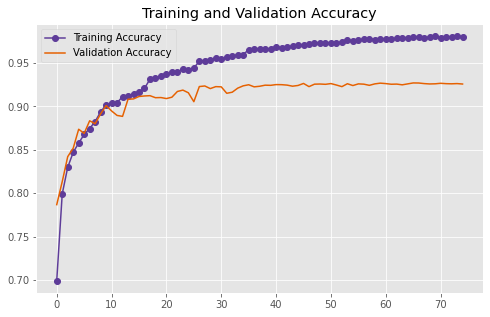

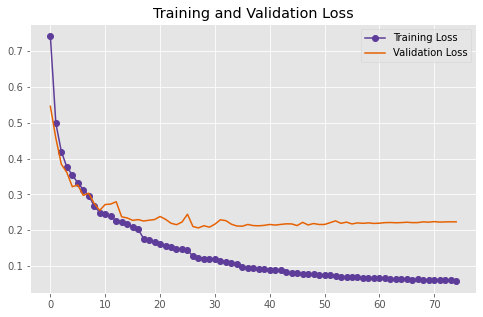

In [ ]:
"""
This is our plot function, which produces two plots:
1) Training and Validation Accuracy vs Epochs
2) Training and Validation Loss vs Epochs
"""
plot_train_curve(history)

# Results Analysis 

The following algorithm and parameters were used for experimentation:
- MLP network
- CNN network (1-3 Layers)
- Loss: Categorical Crossentropy
- Activation Function: ReLu
- Pooling (Average/Max, Pool Size, Stride)
- Convolution (# of Filters, Filter Size, Stride)
- Dropout Layers (different dropout rates)
- Adam Optimizers (varied alpha, AMSGrad variant)
- Step-Decay Drop-Based Learning Rate (initial learning rate, epoch drop, drop rate)
- Varying hidden nodes in Dense layer, epochs, and batch size
- Kernel Initializers (normal, he_normal, he_uniform, lecun_normal, lecun_uniform, glorot_normal, glorot_uniform) 
- Early Stopping

For an in-depth explanation on how each of these parameters/algorithms were tested, please read through the **"Experimentation"** section below.

A comparison of all models from every experiment is shown in the table below:

|Model |Test Accuracy|Test Loss|Summary                                 |Experiment|
|:---: |:-----------:|:-------:|:--------------------------------------:|:--------:|
|**1** |0.877        |0.330    |Baseline MLP                            |**1**     |
|2     |0.911        |0.263    |Baseline 1-Layer CNN                    |2         |
|3     |0.909        |0.271    |Max pooling config                      |2         |
|**4** |0.918        |0.248    |Filter experimentation with Max Pooling |**2**     |
|5     |0.914        |0.253    |Avg. pooling config                     |2         |
|6     |0.905        |0.272    |Filter experimentation with Avg. Pooling|2         |
|7     |0.896        |0.400    |Baseline 2-Layer CNN                    |3         |
|8     |0.891        |0.282    |Tuned 2nd CNN Layer                     |3         |
|**9** |0.924        |0.243    |Hyperparameter-Tuned 2-Layer CNN        |**3**     |
|10    |0.899        |0.264    |Baseline 3-Layer CNN                    |4         |
|11    |0.910        |0.281    |Tuned 3rd CNN Layer                     |4         |
|**12**|0.914        |0.273    |Hyperparameter Tuned 3-Layer CNN        |**4**     |

For clarity, the best models from each experiment are shown in the following table:

|Model |Test Accuracy|Test Loss|Summary     |Experiment|
|:---: |:-----------:|:-------:|:----------:|:--------:|
|**1** |0.877        |0.330    |MLP         |**1**     |
|**4** |0.918        |0.248    |1-Layer CNN |**2**     |
|**9** |0.924        |0.243    |2-Layer CNN |**3**     |
|**12**|0.914        |0.273    |3-Layer CNN |**4**     |

**From the results above, it is clear that the best model out of all experiments is Model 9, which is a 2-Layered CNN network with a test accuracy of 0.924 and a test loss of 0.243! This has the lowest loss and the highest accuracy out of all models!!**

Model 9 has the following architecture:

- 1 Convolution Layer: 32 filters of 5x5, stride 1
- 1 Max Pooling Layer: 3x3 pool, stride 1
- 1 Convolution Layer: 32 filters of 5x5, stride 1
- 1 Max Pooling Layer: 2x2 pool, stride 2
- 1 Dense Layer: 1000 nodes, activation = ReLU 
- 1 Dropout Layer: 10% (0.1)
- 1 Output Layer: 5 nodes, activation = Softmax  

It contains the following hyperparameters:
- Loss: categorical crossentropy
- Optimizer: Adam
- Learning rate: step decay ($LR_i$ = 0.001, $DR$ = 0.6, $E_D$ = 9.0)
- Kernel Initializer: he_uniform
- Batch size: 64
- Epochs: 75

Model 9 displayed the following runtime performance:

|Training Loss|Training Acc.|Val. Loss| Val. Acc.|Test Loss|Test Acc.| 
|:-----------:|:-----------:|:-------:|:--------:|:-------:|:-------:|
|0.060        |0.980        |0.223    |0.926     |0.243    |0.924    |

To examine the plots produced by Model 9, refer to the bottom of [CM5] or the **Kernel Initializer Tuning Summary** in the **Experimentation** section below.



# Experimentation

In [ ]:
from google.colab import drive

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import keras 
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, AveragePooling2D
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import time

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Dataset Analysis & Preprocessing

## Load Dataset

In [ ]:
# Load raw dataset and examine structure
data = np.load("/content/drive/MyDrive/ECE657A - Adi/fashion_mnist_dataset_train.npy", allow_pickle=True).item()
print("RAW DATASET STATS:")
print("Type: {} | Shape: {} | Keys: {} \n".format(type(data), len(data), str(data.keys())))
print("Key: {} | Type: {} | Shape: {} \n".format('features', type(data['features']), data['features'].shape))
print("Key: {} | Type: {} | Shape: {}".format('target', type(data['target']), data['target'].shape))

# Splitting raw dataset into data and labels
feature = data['features']
target  = data['target']   

RAW DATASET STATS:
Type: <class 'dict'> | Shape: 2 | Keys: dict_keys(['features', 'target']) 

Key: features | Type: <class 'numpy.ndarray'> | Shape: (60000, 28, 28) 

Key: target | Type: <class 'numpy.ndarray'> | Shape: (60000,)


## Examine Images

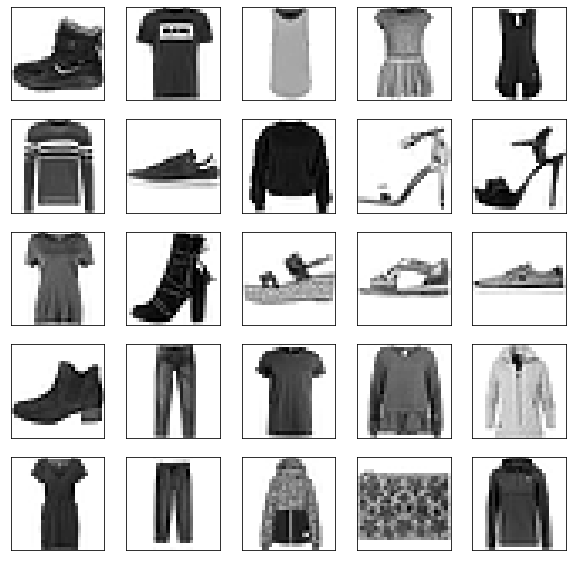

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(feature[i], cmap=plt.cm.binary)
plt.show()

We can see that each image contains a single clothing item and are all grayscale. Since the images do not have an RGB scale, we can reshape the data to have a single color channel.

## Split Dataset

In [ ]:
# create training, validation and testing data with 60/20/20 split
x_trainVal, x_test, y_trainVal, y_test = train_test_split(feature, target, test_size=0.2, random_state=0) 
x_train, x_val, y_train, y_val = train_test_split(x_trainVal, y_trainVal, test_size=0.25, random_state=0)   

# define function to output dataset stats
def dataStats(x_train, y_train, x_val, y_val, x_test, y_test):
  print("Training Set Size - Data: {} | Label: {} \n".format(x_train.shape, y_train.shape))
  print("Validation Set Size - Data: {} | Label: {} \n".format(x_val.shape, y_val.shape))
  print("Testing Set Size - Data: {} | Label: {}".format(x_test.shape, y_test.shape))

dataStats(x_train, y_train, x_val, y_val, x_test, y_test)

train_label = y_train
val_label   = y_val
test_label  = y_test

Training Set Size - Data: (36000, 28, 28) | Label: (36000,) 

Validation Set Size - Data: (12000, 28, 28) | Label: (12000,) 

Testing Set Size - Data: (12000, 28, 28) | Label: (12000,)


## Preprocess Data

In [ ]:
# image dimensions = 28 x 28 pixels
# channels = 1 (grayscale)
img_rows, img_cols, channels = 28, 28, 1

# reshape data to have single channel (grayscale)
kaggle_data   = x_trainVal.reshape((x_trainVal.shape[0], img_rows, img_cols, channels))
train_data    = x_train.reshape((x_train.shape[0], img_rows, img_cols, channels))
val_data      = x_val.reshape((x_val.shape[0], img_rows, img_cols, channels))
test_data     = x_test.reshape((x_test.shape[0], img_rows, img_cols, channels))

# normalize pixel values from [0,255] -> [0,1]
# convert data type from unsigned int to float & divide by 255
kaggle_data = kaggle_data.astype('float32')/255.0
train_data  = train_data.astype('float32')/255.0
val_data    = val_data.astype('float32')/255.0
test_data   = test_data.astype('float32')/255.0
  
# convert labels to one-hot encoding
kaggle_label = y_trainVal.reshape(-1,1)
train_label  = train_label.reshape(-1,1)
val_label    = val_label.reshape(-1,1)
test_label   = test_label.reshape(-1,1)

enc = OneHotEncoder()

# kaggle label
enc.fit(kaggle_label)
kaggle_label = enc.transform(kaggle_label).toarray()

# train label
enc.fit(train_label)
train_label = enc.transform(train_label).toarray()

# val label
enc.fit(val_label)
val_label = enc.transform(val_label).toarray()

# test label
enc.fit(test_label)
test_label = enc.transform(test_label).toarray()

In [ ]:
dataStats(train_data, train_label, val_data, val_label, test_data, test_label)

Training Set Size - Data: (36000, 28, 28, 1) | Label: (36000, 5) 

Validation Set Size - Data: (12000, 28, 28, 1) | Label: (12000, 5) 

Testing Set Size - Data: (12000, 28, 28, 1) | Label: (12000, 5)


# Experiment 1: Sequential Model


## Model 1 - Baseline MLP Model

A baseline sequential model will be defined here. This model will consist of the following architecture:
- Hidden layers = 1, activation function = ReLU
- Output layer activation function: Softmax
- Loss = categorical cross entropy
- Optimizer = Adam (default learning rate = 0.001)

Since this problem involves multi-class classification, categorical cross entropy is used as a loss function along with Softmax for the output layer. ReLU will be used as the activation function for hidden layers, as Ian Goodfellow states many beneficial reasons for using it as opposed to the traditional Sigmoid unit in his *Deep Learning* book $^{1}$. Adam is used here as it is a default optimization algorithm in Deep Learning applications and "is generally regarded as being fairly robust to the choice of hyperparameters, though the learning rate sometimes needs to be changed from the suggested default$^{2}$". There is a strong correlation between batch size and learning rate, as shown by Kandel El. Al $^{3}$. When finalizing a model, the learning rate will be tuned along with the batch size to achieve the best possible model.

Experimentation will begin here to examine the effect between training epochs and the number of hidden nodes. The number of epochs will be kept within 40 and hidden nodes within 1000, while the batch size will be set to 64 for now. GridSearchCV will be utilized to perform an exhaustive scan over the parameters mentioned above to find the best configuration for each model with a varying number of hidden nodes. It performs cross-validation as well - we will set cv = 3 here since a lower cv will increase the speed of GridSearchCV without a meanginful difference in performance estimation$^{4}$.

**References**
1.  https://www.deeplearningbook.org/contents/mlp.html 

2. https://www.deeplearningbook.org/contents/optimization.html

3. https://www.sciencedirect.com/science/article/pii/S2405959519303455#:~:text=For%20both%20the%20datasets%2C%20the,impact%20on%20the%20CNN%20performance.

4. https://stackoverflow.com/questions/35655701/is-there-a-quicker-way-of-running-gridsearchcv 

In [ ]:
def create_model(H):
	# create model
  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Flatten())
  model.add(Dense(H, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam(lr=1e-3)
               )	
  return model

hiddenLayerNodes = [50,100,250,500,1000]

t0 = time.time()
for H in hiddenLayerNodes:
  model = KerasClassifier(build_fn=create_model, H = H, verbose=0)

  # define the grid search parameters
  batch_size = [64]
  epochs = [5,10,15,20,25,30]

  param_grid = dict(batch_size=batch_size, epochs=epochs)
  grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
  grid_result = grid.fit(train_data, train_label)
  
  # summarize results
  print("Best: {} | Parameters: {} | Hidden Nodes: {}".format(grid_result.best_score_, grid_result.best_params_, H))
  print("\n")

t1 = time.time()
print("Time for experiment: {} minutes".format(round((t1-t0)/60, 2)))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.7846111257870992 | Parameters: {'batch_size': 64, 'epochs': 30} | Hidden Nodes: 50


Best: 0.8026666641235352 | Parameters: {'batch_size': 64, 'epochs': 30} | Hidden Nodes: 100


Best: 0.8313888907432556 | Parameters: {'batch_size': 64, 'epochs': 30} | Hidden Nodes: 250


Best: 0.8468611041704813 | Parameters: {'batch_size': 64, 'epochs': 30} | Hidden Nodes: 500


Best: 0.8619444370269775 | Parameters: {'batch_size': 64, 'epochs': 30} | Hidden Nodes: 1000


Time for experiment: 13.62 minutes


The following conclusions are drawn from the results of Experiment 1:
- There is a positive correlation between model accuracy and the number of nodes in the hidden layer
- Every model permutation performed the best with 30 epochs, which is the maximum amount tested for this experiment
- The first two conclusions suggest that this baseline model configuration is capable of handling further training and/or more hidden nodes

Moving forward, the dense portion of our CNN models will utilize 1000 nodes in its first hidden layer. The number of epochs however, will be increased in later experiments when testing on validation and testing sets to see if this improves the perfomance of future models. For hyperparameter investigations involving GridSearchCV, 30 epochs will be used for feasibility as GridSearchCV takes a very long time to execute.



### Test Set Evaluation

The optimal configuration of the baseline Sequential model will be evaluated using our validation set, then tested on the test set:

In [ ]:
model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam(lr=1e-3)
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, epochs=30, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nSequential Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

In [ ]:
def plot_train_curve(history):
    colors = ['#e66101','#fdb863','#b2abd2','#5e3c99']
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, accuracy, marker='o', c=colors[3], label='Training Accuracy')
        plt.plot(epochs, val_accuracy, c=colors[0], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, loss, marker='o', c=colors[3], label='Training Loss')
        plt.plot(epochs, val_loss, c=colors[0], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

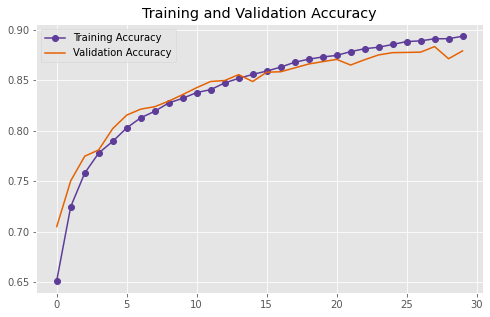

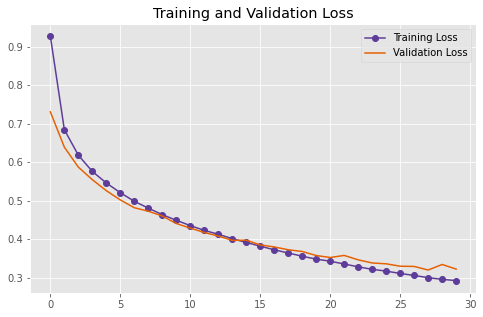

In [ ]:
plot_train_curve(history)

The baseline sequential model achieves a suprising result: **accuracy of 0.877 on the test set with a loss of 0.330**. Examining the plots above, we can see both the training and validation loss were steadily decreasing whereas the training accuracy and testing accuracy were steadily increasing (with minor fluctuations toward the end). These are good signs and further validates the conclusion that this model can handle more training - the number of epochs will be increased to 100 as a result.

# Experiment 2: 1-Layer CNN Model

Experiment 2 will focus on developing a CNN by extending the model from Experiment 1 to include a layer of convolution. 

## Model 2 - Baseline 1-Layer CNN

First, a baseline CNN model will be defined. The architecture of this model will be extended in the following way:
- A Convolution network will preceed the Fully-Connected-Feedforward-Network of Experiment 1
- Conv2D will be used with 32 filters, sized 3x3
- MaxPooling will be used, sized 2x2

The convolution architecture used here is based on many CNN models found online, which use this configuration as a baseline $^{1}$. It is best practice to use smaller filters in the beginning of a CNN. As stated in Lecture 12A of this course, the first convolution layer is usually very simple because it focuses on differences between individual pixels (ex. gabor filters, edge detectors, etc.) whereas response outputs in deeper layers deal with a very large portion of every image and focuses on complex structures $^{2}$. Therefore, the filter size is usually proportional to the depth in order to capture the essential structure of the image first, then build up to capture complex shapes; general filter sizes are 3x3, 5x5 or 7x7 for moderate or small-sized images $^{3}$. Since the activation maps produced by convolution and pooling are smaller than the original image, the corners/edges of an image will often be overlooked unless padding is used. In the section of this report titled "Dataset Analysis & Preprocessing", we examined the images in the dataset to understand the data. It can be seen that each garment (with the exception of the bag/purse, which cuts it close to both left and right sides of the image) is placed in the middle of each image, with plenty of whitespace surrounding it. Therefore, padding is not necessary here as the outline of each item does not generally come close to the image borders. We try using max pooling here to start, since it takes the strongest response among a set of pixels and this might help the model better learn the essentials of each image $^{2}$.

**References**
1. https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/ 
2. Professor Mark Crowley, Lecture 12A 
3. https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7 

### Test Set Evaluation

In [ ]:
model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam(lr=1e-3)
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, epochs=100, shuffle=True)

# Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

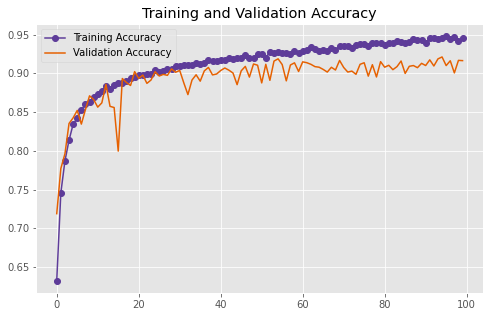

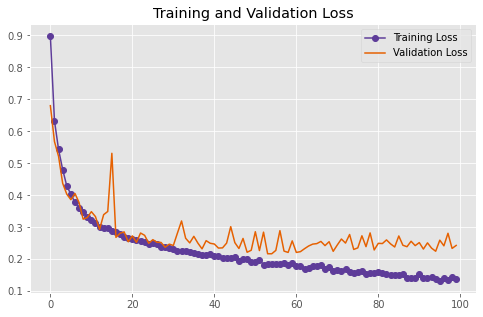

In [ ]:
plot_train_curve(history)

The baseline CNN model beats the Sequential model of Experiment 1, achieving the following metrics: **accuracy of 0.911 on the test set with a loss of 0.263** - impressive results! The plots above show coarser accuracy and loss curves, but have the general trend of the accuracy increasing and the loss decreasing.

## Model 3 - Altering Size and Stride for MaxPooling

In this portion, the size and stride of the pooling layers will be investigated for MaxPooling. Many ML engineers typically opt for max pooling, with a size of either 2x2 or 3x3 with a stride of the same length$^{1}$ - by default, the pooling layers in Keras also specify the stride to be the same as the pooling size by default. As such, the following pooling parameters will be tested in this experiment:
- Pooling Sizes: 2x2 or 3x3
- Strides: 1, 2, 3, 4

1. https://datascience.stackexchange.com/questions/19455/how-can-you-decide-the-window-size-on-a-pooling-layer 

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(pool_size, stride):
	# create model
  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='normal'))
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size), strides=stride))
  model.add(Flatten())
  model.add(Dense(1000, activation='relu'))
  model.add(Dense(5, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam(lr=1e-3)
               )	
  return model

begin = time.time()

# instantiate model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [64]
epochs = [30]
pool_size = [2,3]
stride = [1,2,3,4]
              
param_grid = dict(batch_size=batch_size, epochs=epochs, pool_size=pool_size, stride=stride)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_data, train_label)
  
# summarize results
print("Best: {} | Parameters: {}".format(grid_result.best_score_, grid_result.best_params_))
# print("# of Filters: {} | Filter Size: {}".format(filters,size))
print("\n")

end = time.time()
print("TOTAL GRIDSEARCH TIME: {} MINUTES".format((end-begin)/60))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.890499989191691 | Parameters: {'batch_size': 64, 'epochs': 30, 'pool_size': 3, 'stride': 1}


TOTAL GRIDSEARCH TIME: 16.154048454761504 MINUTES


GridSearchCV suggests the best max pooling configuration to have a size of 3x3 with a stride of 1 - this configuration will be evaluated on the test set:

### Test Set Evaluation

In [ ]:
model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam(lr=1e-3)
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, epochs=100, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

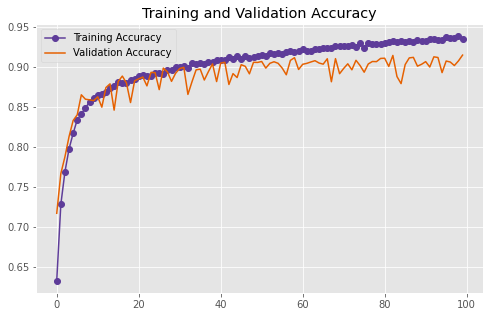

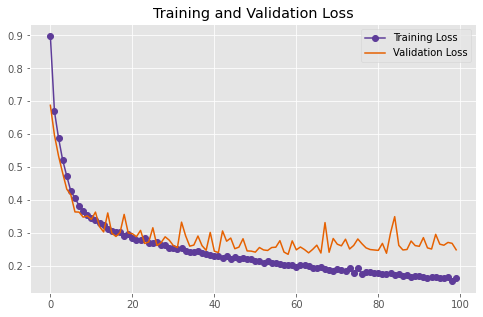

In [ ]:
plot_train_curve(history)

Model 3 achieves the following metrics: **accuracy of 0.909 on the test set with a loss of 0.271**. This performs slightly worse than Model 1. However, achieving a robust model architecture typically involves trying a combination of different layers out together and hyperparameter tuning them as a whole. Therefore, we will proceed with the recommended configuration of the max pooling layer and try to alter the convolution filter parameters in the next model.

## Model 4 - Altering Filter Parameters for MaxPooling

Here, we will alter the number of filters along with their size for the convolution layer. As mentioned before, we will keep the recommended max pooling configuration suggested by gridsearch and see if we can achieve a model better than the 1D CNN baseline through this experiment. The following filter parameters will be tested:
- Number of Filter: 8, 16, 32
- Filter Sizes: 3, 5


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(numFilters, filterSize):
	# create model
  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(numFilters, (filterSize, filterSize), activation='relu', kernel_initializer='normal'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
  model.add(Flatten())
  model.add(Dense(1000, activation='relu'))
  model.add(Dense(5, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam(lr=1e-3)
               )	
  return model

numFilters = [8,16,32]
filterSize = [3,5]

begin = time.time()

for filters in numFilters:
  for size in filterSize:

    model = KerasClassifier(build_fn=create_model, numFilters = filters, filterSize = size, verbose=0)

    # define the grid search parameters
    batch_size = [64]
    epochs = [30]

    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(train_data, train_label)
    
    # summarize results
    print("Best: {} | Parameters: {}".format(grid_result.best_score_, grid_result.best_params_))
    print("# of Filters: {} | Filter Size: {}".format(filters,size))
    print("\n")
end = time.time()
print("TOTAL GRIDSEARCH TIME: {} MINUTES".format((end-begin)/60))

Best: 0.41877777377764386 | Parameters: {'batch_size': 64, 'epochs': 30}
# of Filters: 8 | Filter Size: 3


Best: 0.870472232500712 | Parameters: {'batch_size': 64, 'epochs': 30}
# of Filters: 8 | Filter Size: 5


Best: 0.8788333336512247 | Parameters: {'batch_size': 64, 'epochs': 30}
# of Filters: 16 | Filter Size: 3




/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.8866111040115356 | Parameters: {'batch_size': 64, 'epochs': 30}
# of Filters: 16 | Filter Size: 5


Best: 0.8729166785875956 | Parameters: {'batch_size': 64, 'epochs': 30}
# of Filters: 32 | Filter Size: 3


Best: 0.8915277719497681 | Parameters: {'batch_size': 64, 'epochs': 30}
# of Filters: 32 | Filter Size: 5


TOTAL GRIDSEARCH TIME: 18.34483050107956 MINUTES


GridSearchCV suggests the top filter configuration to have 32 filters sized 5x5, and the second best configuration to have 16 filters with a size of 5x5 - both will be evaluated on the test set:

### Testing 1st Place: 32 Filters, 5x5

In [ ]:
model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam(lr=1e-3)
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, epochs=100, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

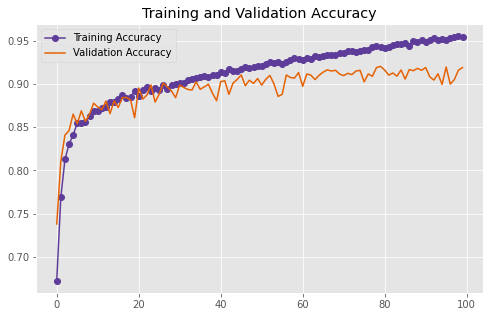

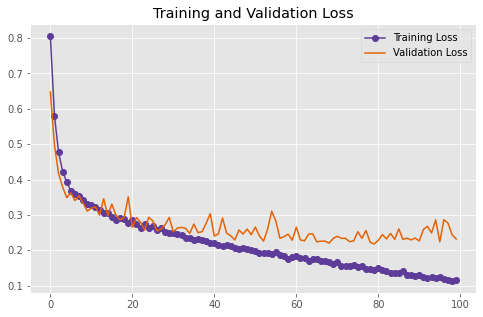

In [ ]:
plot_train_curve(history)

This configuration achieved the best result so far and boasts the following metrics: **test accuracy of 0.918 and a test loss of 0.248**! Let's see if using 16 filters works better:

### Testing 2nd Place: 16 Filters, 5x5

In [ ]:
model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(16, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam(lr=1e-3)
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, epochs=100, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

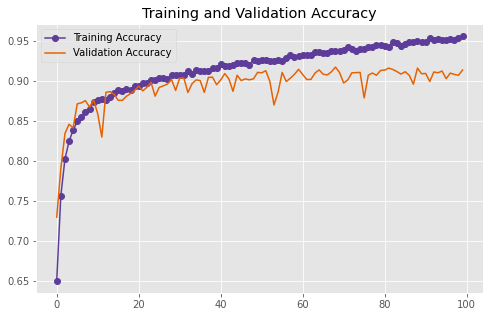

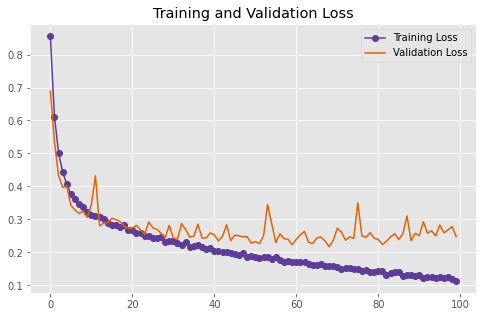

In [ ]:
plot_train_curve(history)

This model has a lower accuracy and a higher loss than the prior model with 32 filters.

## Model 5 - Altering Size and Stride for AveragePooling

In this portion, the size and stride of the pooling layers will be investigated for AveragePooling using the same size and stride configurations as before:

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(pool_size, stride):
	# create model
  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='normal'))
  model.add(AveragePooling2D(pool_size=(pool_size, pool_size), strides=stride))
  model.add(Flatten())
  model.add(Dense(1000, activation='relu'))
  model.add(Dense(5, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam(lr=1e-3)
               )	
  return model

begin = time.time()

# instantiate model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [64]
epochs = [30]
pool_size = [2,3]
stride = [1,2,3,4]
              
param_grid = dict(batch_size=batch_size, epochs=epochs, pool_size=pool_size, stride=stride)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_data, train_label)
  
# summarize results
print("Best: {} | Parameters: {}".format(grid_result.best_score_, grid_result.best_params_))
print("\n")

end = time.time()
print("TOTAL GRIDSEARCH TIME: {} MINUTES".format((end-begin)/60))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.8887777725855509 | Parameters: {'batch_size': 64, 'epochs': 30, 'pool_size': 2, 'stride': 1}


TOTAL GRIDSEARCH TIME: 16.10569635629654 MINUTES


Compared to max pooling which worked best with a size of 3x3, gridsearch states that a smaller pool size of 2x2 works better for average pooling. Let's see how it performs on the test set:

### Test Set Evaluation

In [ ]:
model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='normal'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=1))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam(lr=1e-3)
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, epochs=100, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

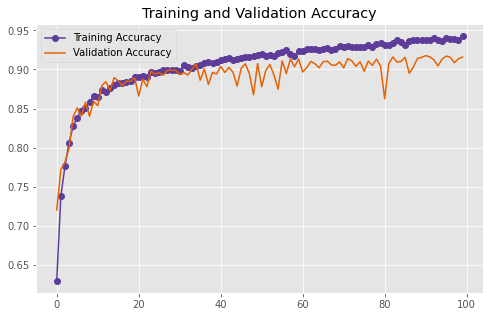

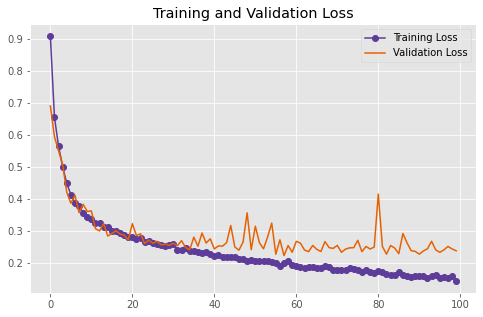

In [ ]:
plot_train_curve(history)

This model achieves the following metrics: **test accuracy of 0.914 and a test loss of 0.253**. Model 3, which used max pooling, performed worse achieving the following metrics: **test accuracy of 0.909 and a test loss of 0.271**. This seems promising, maybe tuning the filter parameters with this average pooling configuration will yield better results - let's find out!

## Model 6 - Altering Filter Parameters for AveragePooling

We test the same filter configurations as Model 4 to find out how average pooling performs with varied convolution parameters:

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(numFilters, filterSize):
	# create model
  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(numFilters, (filterSize, filterSize), activation='relu', kernel_initializer='normal'))
  model.add(AveragePooling2D(pool_size=(2, 2), strides=1))
  model.add(Flatten())
  model.add(Dense(1000, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam(lr=1e-3)
               )	
  return model

numFilters = [8,16,32]
filterSize = [3,5]

begin = time.time()

for filters in numFilters:
  for size in filterSize:

    model = KerasClassifier(build_fn=create_model, numFilters = filters, filterSize = size, verbose=0)

    # define the grid search parameters
    batch_size = [64]
    epochs = [30]

    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(train_data, train_label)
    
    # summarize results
    print("Best: {} | Parameters: {}".format(grid_result.best_score_, grid_result.best_params_))
    print("# of Filters: {} | Filter Size: {}".format(filters,size))
    print("\n")
end = time.time()
print("TOTAL GRIDSEARCH TIME: {} MINUTES".format((end-begin)/60))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.8861666719118754 | Parameters: {'batch_size': 64, 'epochs': 30}
# of Filters: 8 | Filter Size: 3


Best: 0.8877222140630087 | Parameters: {'batch_size': 64, 'epochs': 30}
# of Filters: 8 | Filter Size: 5


Best: 0.8836666544278463 | Parameters: {'batch_size': 64, 'epochs': 30}
# of Filters: 16 | Filter Size: 3


Best: 0.8840277791023254 | Parameters: {'batch_size': 64, 'epochs': 30}
# of Filters: 16 | Filter Size: 5


Best: 0.887333333492279 | Parameters: {'batch_size': 64, 'epochs': 30}
# of Filters: 32 | Filter Size: 3


Best: 0.8806666731834412 | Parameters: {'batch_size': 64, 'epochs': 30}
# of Filters: 32 | Filter Size: 5


TOTAL GRIDSEARCH TIME: 19.776330395539603 MINUTES


### Testing 1st Place: 8 Filters, 5x5

In [ ]:
model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(8, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=1))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam(lr=1e-3)
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, epochs=100, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

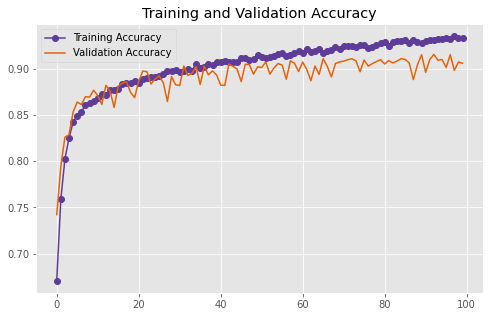

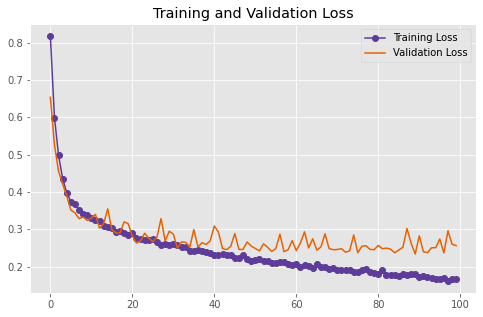

In [ ]:
plot_train_curve(history)

### Testing 2nd Place: 16 Filters, 5x5

In [ ]:
model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(16, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=1))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam(lr=1e-3)
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, epochs=100, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

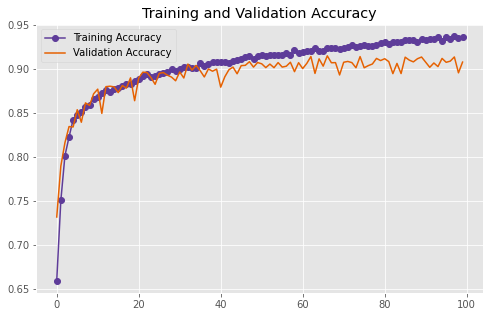

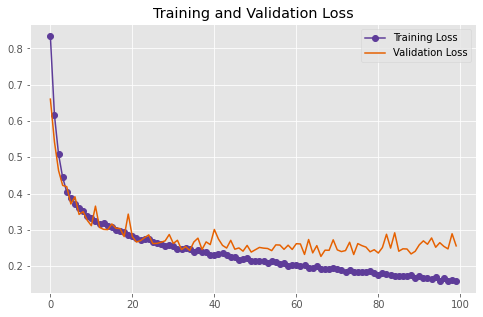

In [ ]:
plot_train_curve(history)

Despite the optimistic result gained from our average pooling experimentation in Model 5, average pooling unfortunately does not perform better than max pooling when the convolution parameters are adjusted. Therefore, we will disregard using average pooling from here out and stick to building our models using max pooling.

## Final Results for 1-Layer CNN Models

The results from all our models thus far (including model 1 from experiment 1) are summarized below:

|Model|Test Accuracy|Test Loss|Summary                                 |
|:---:|:-----------:|:-------:|:--------------------------------------:|
|1    |0.877        |0.330    |Baseline MLP                            |
|2    |0.911        |0.263    |Baseline 1D CNN                         |
|3    |0.909        |0.271    |Max pooling config                      |
|4    |0.918        |0.248    |Filter experimentation with Max Pooling |
|5    |0.914        |0.253    |Avg. pooling config                     |
|6    |0.905        |0.272    |Filter experimentation with Avg. Pooling|

Our analysis so far conveys the following: **Model 4 boasts the highest test accuracy of 0.918 and also the lowest loss of 0.248!** 

It contains the following architecture:

- 1 Convolution Layer: 32 filters of 5x5, stride 1
- 1 Max Pooling Layer: 3x3 pool, stride 1
- 1 Dense Layer: 1000 nodes, activation = ReLU 
- 1 Output Layer: 5 nodes, activation = Softmax   

It contains the following hyperparameters:
- Loss: categorical crossentropy
- Optimizer: Adam, learning rate = 0.001
- Batch size = 64
- Epochs = 100

We will build upon this configuration to develop CNN networks with deeper layers. Let's start by adding an additional CNN layer and taking it one step at a time!

# Experiment 3: 2-Layer CNN Model

This experiment will use the best configuration from Experiment 1 (ie. Model 4) and build upon it to produce the best possible 2-Layered CNN network. It is well known that large, shallow models overfit more whereas deeper models are more robust and exhibit better generalization with greater depth $^{1}$. As such, we will try to build a deeper model (upto 3 layers) which take advantage of this property. Vanishing gradients are typically a concern for deeper models, but can luckily be tackled using ReLu activation functions $^{2}$.

**References:**

(1) Professor Mark Crowley, Lecture 12A

(2) Professor Mark Crowley, Lecture 11B


## Model 7 - Baseline 2-Layer CNN

We will duplicate the 1st convolution layer as the 2nd layer and examine how the model does - this will be our baseline 2D CNN model:

In [ ]:
model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam(lr=1e-3)
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, epochs=90, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

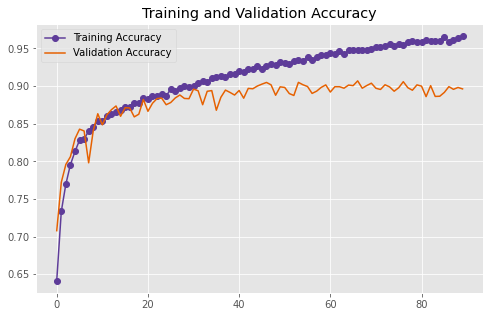

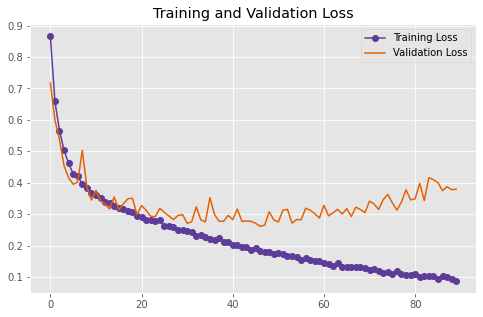

In [ ]:
plot_train_curve(history)

Model 7 performs poorly compared to Model 6 and achieves the following metrics: **test accuracy of 0.896 and a test loss of 0.400**. We can also see the validation loss hit a minimum then starts to increase again after ~45 epochs, which is indicative of overtraining. Let's try to tune the 2nd layer by using the same strategy as before: tuning the pooling layer then the filter parameters.

## Model 8 - Altering 2nd Convolution Layer

### Tuning 2nd Layer of Convolution

Here we will perform GridSearchCV to find the optimal filter parameters for the 2nd convolution layer, including the effect of filter strides (Note: by default, Keras uses a convolution stride of 1 by default):

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(numFilters, filterSize, strides):
	# create model
  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
  model.add(Conv2D(numFilters, (filterSize, filterSize), strides=strides, activation='relu', kernel_initializer='normal'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(Flatten())
  model.add(Dense(1000, activation='relu'))
  model.add(Dense(5, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam(lr=1e-3)
               )	
  return model

begin = time.time()

model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
numFilters = [8,16,32]
filterSize = [3,5]
strides = [1,2,3]
batch_size = [64]
epochs = [30]

param_grid = dict(numFilters=numFilters,
                  filterSize=filterSize,
                  strides=strides,
                  batch_size=batch_size, 
                  epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_data, train_label)

# summarize results
print("Best: {} | Parameters: {}".format(grid_result.best_score_, grid_result.best_params_))
print("\n")
end = time.time()
print("TOTAL GRIDSEARCH TIME: {} MINUTES".format((end-begin)/60))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.8801388740539551 | Parameters: {'batch_size': 64, 'epochs': 30, 'filterSize': 5, 'numFilters': 32, 'strides': 1}


TOTAL GRIDSEARCH TIME: 25.222642616430917 MINUTES


The search recommended a configuration which is the same as the 2-Layer baseline CNN model! Let's move onto tuning the pooling layer.

### Tuning 2nd Layer of Pooling

For this experiment, we will use 30 epochs to make hyperparameter tuning feasible:

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(pool_size, pool_stride):
	# create model
  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size), strides=pool_stride))
  model.add(Flatten())
  model.add(Dense(1000, activation='relu'))
  model.add(Dense(5, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam(lr=1e-3)
               )	
  
  return model

begin = time.time()

model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
pool_size = [2,3]
pool_stride = [1,2,3,4]
batch_size = [64]
epochs = [30]

param_grid = dict(batch_size=batch_size, 
                  pool_size=pool_size, 
                  pool_stride=pool_stride,
                  epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
grid_result = grid.fit(train_data, train_label)

# summarize results
print("Best: {} | Parameters: {}".format(grid_result.best_score_, grid_result.best_params_))
print("\n")

end = time.time()
print("TOTAL GRIDSEARCH TIME: {} MINUTES".format((end-begin)/60))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 15.1min finished


Best: 0.8866666754086813 | Parameters: {'batch_size': 64, 'epochs': 30, 'pool_size': 2, 'pool_stride': 2}


TOTAL GRIDSEARCH TIME: 15.930778682231903 MINUTES


GridSearchCV suggests using a size of 2x2 with a stride of 2 for the max pooling layer. Let's test it out!

### Testing Improved Convolution Layer

In [ ]:
model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam(lr=1e-3)
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, epochs=100, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

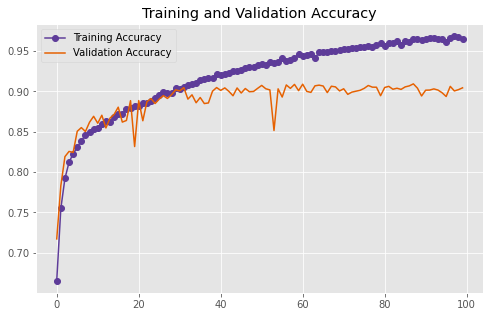

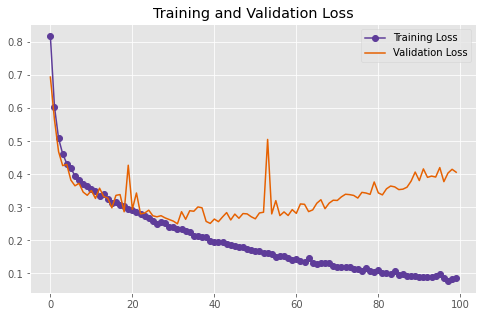

In [ ]:
plot_train_curve(history)

Model 8 achieves a slight increase in accuracy and a slight decrease in loss, but the validation curve still shows overfitting. Let's try to use the early stopping regularization technique and stop training the model around 30 epochs!


### Testing with Early Stopping

In [ ]:
model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam(lr=1e-3)
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, epochs=30, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

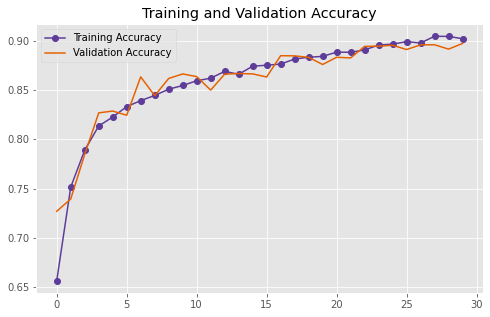

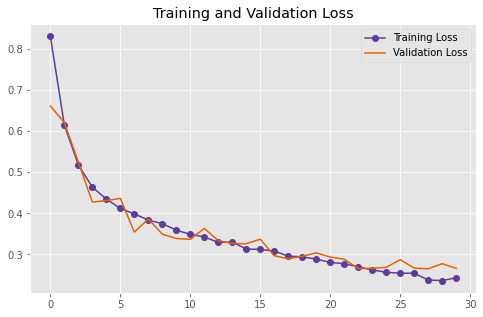

In [ ]:
plot_train_curve(history)

This model achieves a slightly lower accuracy but also a much lower loss, which is better! We can see that this version of the model does not overfit. We will now try a series of hyperparameter tuning methods to try and push the capabilities of the model further - I have a feeling there is still some potential to reveal here!

## Model 9 - Hyperparameter Tuning

In this section, we will take our resultant 2-Layer CNN model which was achieved through experimentation and vary the optimizers parameters, add dropout units, use early stopping, and alter kernel initializers to promote the best results.

### Adam Optimizer Settings

#### Validating Adam Alpha Parameter

Let's start by validating whether we've been using the correct alpha with our Adam optimizer. Note that Adam is an adaptive learning rate optimizer, and compared to SGD which maintains a single learning rate for all weight updates, Adam "computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients"$^{1}$. In addition to the alpha, Adam has parameters beta1 and beta2 to control the decay rates of these moving averages$^{1}$. Here, we will vary the number of epochs along with the alpha learning rate and see which configuration works best:

 **References:**

(1) https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ 

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(lr):
	# create model
  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(Flatten())
  model.add(Dense(1000, activation='relu'))
  model.add(Dense(5, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam(lr=lr)
               )	
  return model

begin = time.time()

model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
lr = [0.1,0.01,0.001,0.0001]
epochs = [20,30,40,50]
batch_size = [64]

param_grid = dict(lr=lr,
                  batch_size=batch_size, 
                  epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
grid_result = grid.fit(train_data, train_label)

# summarize results
print("Best: {} | Parameters: {}".format(grid_result.best_score_, grid_result.best_params_))
print("\n")
end = time.time()
print("TOTAL GRIDSEARCH TIME: {} MINUTES".format((end-begin)/60))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 32.1min finished


Best: 0.8952777783075968 | Parameters: {'batch_size': 64, 'epochs': 30, 'lr': 0.001}


TOTAL GRIDSEARCH TIME: 33.08492389520009 MINUTES


The default alpha of 0.001 with 30 epochs seems to be the best choice, which is what we've been using before - we already had a great configuration!

#### AMSGrad Variant of Adam

This option is available in the Adam optimizer for Keras and is simply activated with the parameter "amsgrad = True"$^{1}$. This parameter determines whether to apply the "AMSGrad variant of this algorithm from the paper titled *On the Convergence of Adam and beyond*"$^{2}$. The AMSGrad scheme seeks to overcome a flaw in Adams proof of convergence, but in practicality it performs on par with Adam (as shown by Filip Korzeniowski $^{3}$) or sometimes even worse (as shown by Sylvain Gugger and Jeremy Howard $^{4}$) . Regardless, we will apply it to our own model to see if it is beneficial to us:

**References:**

(1) https://keras.io/api/optimizers/adam/

(2) https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c

(3) https://fdlm.github.io/post/amsgrad/ 

(4) https://www.fast.ai/2018/07/02/adam-weight-decay/ 
 

In [ ]:
from keras.callbacks import LearningRateScheduler
import math 

model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam(amsgrad = True)
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64,
                    epochs=30, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

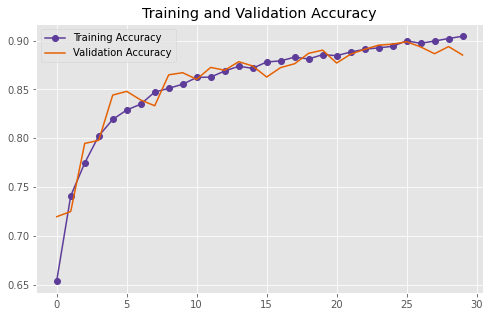

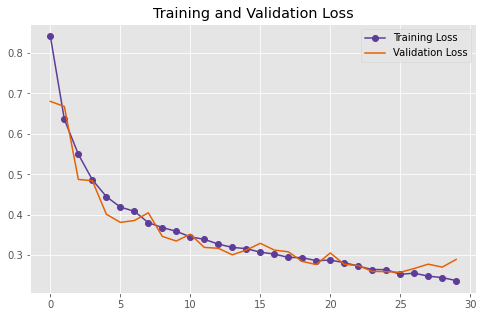

In [ ]:
plot_train_curve(history)

The AMSGrad produces decent results, but performs worse than our best 2D CNN model, which is Model 8 with early stopping. Based on this and the reports from other established researchers, we will disregard the AMSGrad variant of Adam.

#### Step Decay

Instead of using the decay methods in Adam, let's define our own decay method and use a callback function to implement it. Here we will try a drop-based learning rate method called step decay, which uses the following formula$^{1}$:

---

$LR = LR_i * DR^{floor(E/E_d)}$

where:

$LR$ = Learning Rate (calculated)

$LR_i$ = Initial Learning Rate

$DR$ = Drop Rate (the amount that the learning rate is modified each time)

$E$ = Epoch (current epoch number)

$E_d$ = Epoch Drop (how often to change the learning rate)

---

The following section will use Adams default alpha of 0.001 as the initial learning rate, and a drop of 0.5 every 10 epochs. The results of this scheme are shown below:

**Resources:**

(1) https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/ 

In [ ]:
from keras.callbacks import LearningRateScheduler
import math 

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

lrScheduler = LearningRateScheduler(step_decay)

model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam()
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, callbacks= lrScheduler,
                    epochs=30, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

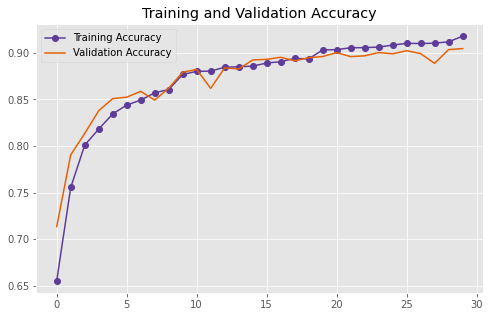

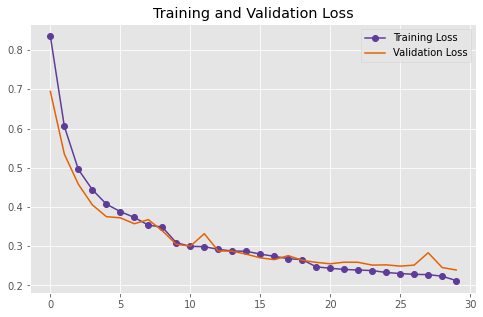

In [ ]:
plot_train_curve(history)

The plots look much better! It seems like we can go for more epochs. In this following section, we increased the number of epochs to 75 and played around with the drop and the epochs_drop parameters in the step_decay function. The following configuration resulted in our best model for 2-Layer CNN so far:

In [ ]:
from keras.callbacks import LearningRateScheduler
import math 

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

lrScheduler = LearningRateScheduler(step_decay)

model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam()
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, callbacks= lrScheduler,
                    epochs=75, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

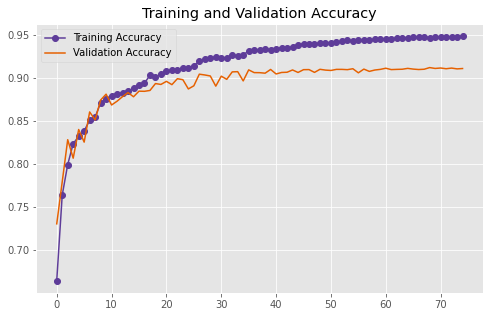

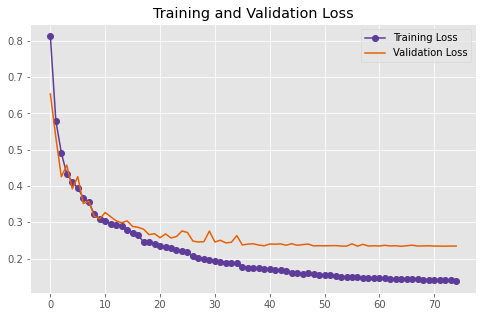

In [ ]:
plot_train_curve(history)

This is the best 2D CNN model so far! It achieves the following metrics: **test accuracy of 0.910 and a test loss of 0.252**! 

### Dropout Layers

We will now continue building from our best model configuration and try adding a dropout layer in the beginning of the fully connected network (before the first Dense layer) as a regularization method. GridSearchCV will be utilized to scan for the best dropout rate from 0.1 to 0.8 in increments of 0.1:

In [ ]:
from keras.callbacks import LearningRateScheduler
import math
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

def create_model(dropout):
	# create model
  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(Flatten())
  model.add(Dropout(dropout))
  model.add(Dense(1000, activation='relu'))
  model.add(Dense(5, activation='softmax'))

    # Compile model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam()
  )
  return model

lrScheduler = LearningRateScheduler(step_decay)

begin = time.time()

model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [64]
epochs = [75]
dropout = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

param_grid = dict(batch_size=batch_size, epochs=epochs, dropout=dropout)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
grid_result = grid.fit(train_data, train_label, callbacks=[lrScheduler])

# summarize results
print("Best: {} | Parameters: {}".format(grid_result.best_score_, grid_result.best_params_))

end = time.time()
print("\nTOTAL GRIDSEARCH TIME: {} MINUTES".format((end-begin)/60))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 34.1min finished


Best: 0.8938888907432556 | Parameters: {'batch_size': 64, 'dropout': 0.1, 'epochs': 75}

TOTAL GRIDSEARCH TIME: 36.25071761210759 MINUTES


A dropout with 0.1 is suggested, let's test it out:

In [ ]:
from keras.callbacks import LearningRateScheduler
import math 

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

lrScheduler = LearningRateScheduler(step_decay)

model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam()
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, callbacks= lrScheduler,
                    epochs=75, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

Epoch 1/75
563/563 [==============================] - 4s 6ms/step - loss: 1.0151 - acc: 0.5748 - val_loss: 0.6330 - val_acc: 0.7490
Epoch 2/75
563/563 [==============================] - 3s 5ms/step - loss: 0.6250 - acc: 0.7478 - val_loss: 0.5430 - val_acc: 0.7822
Epoch 3/75
563/563 [==============================] - 3s 5ms/step - loss: 0.5321 - acc: 0.7871 - val_loss: 0.5162 - val_acc: 0.7861
Epoch 4/75
563/563 [==============================] - 3s 5ms/step - loss: 0.4829 - acc: 0.8058 - val_loss: 0.4213 - val_acc: 0.8307
Epoch 5/75
563/563 [==============================] - 3s 5ms/step - loss: 0.4414 - acc: 0.8217 - val_loss: 0.4024 - val_acc: 0.8346
Epoch 6/75
563/563 [==============================] - 3s 5ms/step - loss: 0.4190 - acc: 0.8310 - val_loss: 0.3678 - val_acc: 0.8574
Epoch 7/75
563/563 [==============================] - 3s 5ms/step - loss: 0.3999 - acc: 0.8412 - val_loss: 0.3708 - val_acc: 0.8511
Epoch 8/75
563/563 [==============================] - 3s 5ms/step - loss: 0.

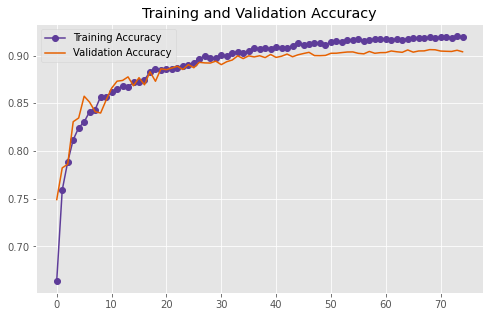

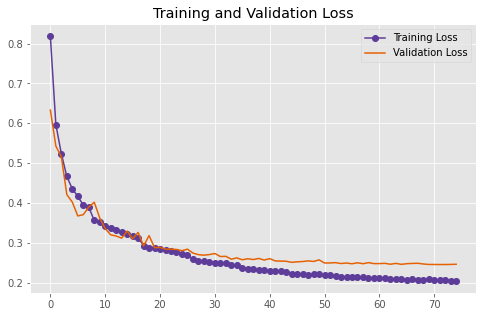

In [ ]:
plot_train_curve(history)

The model falls short in terms of accuracy and has a higher loss, but the plots indicate a much smoother relationship between the training and validation sets. We will take this suggested dropout layer forward and try to pair it with varying kernel initialization methods.

### Kernel Initializers

Kernel initializers define the way to set the initial random weights of Keras layers $^{1}$. In this paper by Huimin Li Et. Al. from Delft University of Technology, Huimin and his team worked on analyzing "how weight initializers’ choice influences deep neural
networks’ performance" and one of their conclusions "show that different weight initializers provide radically different behavior"$^{2}$. Up till now, he have used a normal distribution scheme. Keras uses the glorot uniform scheme by default for CNN, Dense and LSTM layers. We will examine the effects of six initialization schemes:
- lecun_uniform 
- lecun_normal
- glorot_uniform 
- glorot_normal 
- he_uniform
- he_normal

Exepriments will be conducted with and without the dropout layer to see the combined effect of each model architecture (we will use a dropout of 0.1 as this was suggested by GridSearchCV as the best value to use).

**References:**

(1) https://keras.io/api/layers/initializers/ 

(2) https://eprint.iacr.org/2020/904.pdf 

#### With Dropout Layer

In [ ]:
from keras.callbacks import LearningRateScheduler
import math 


begin = time.time()

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

kernel = ['lecun_uniform', 
          'lecun_normal', 
          'glorot_uniform', 
          'glorot_normal',  
          'he_uniform', 
          'he_normal']

for config in kernel:

  lrScheduler = LearningRateScheduler(step_decay)

  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer=config))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer=config))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(Flatten())
  model.add(Dense(1000, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(5, activation='softmax'))

  #Compile the model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam()
              )

  # Train the model
  history = model.fit(train_data, train_label,
                      validation_data = (val_data, val_label),
                      batch_size=64, callbacks= lrScheduler,
                      epochs=75, verbose = 0,
                      shuffle=True)

  #Testing the Model
  score = model.evaluate(test_data, test_label, verbose=1)
  print('\nCNN Performance on Test Set with "{}" initializer'.format(config))
  print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

end = time.time()
print("\nTOTAL TIME: {} MINUTES".format((end-begin)/60))

375/375 [==============================] - 1s 2ms/step - loss: 0.2459 - acc: 0.9186

CNN Performance on Test Set with "lecun_uniform" initializer
Test Accuracy = 0.919 | Test Loss = 0.246
375/375 [==============================] - 1s 2ms/step - loss: 0.2254 - acc: 0.9181

CNN Performance on Test Set with "lecun_normal" initializer
Test Accuracy = 0.918 | Test Loss = 0.225
375/375 [==============================] - 1s 2ms/step - loss: 0.2468 - acc: 0.9123

CNN Performance on Test Set with "glorot_uniform" initializer
Test Accuracy = 0.912 | Test Loss = 0.247
375/375 [==============================] - 1s 2ms/step - loss: 0.2469 - acc: 0.9108

CNN Performance on Test Set with "glorot_normal" initializer
Test Accuracy = 0.911 | Test Loss = 0.247
375/375 [==============================] - 1s 2ms/step - loss: 0.2513 - acc: 0.9243

CNN Performance on Test Set with "he_uniform" initializer
Test Accuracy = 0.924 | Test Loss = 0.251
375/375 [==============================] - 1s 2ms/step - loss: 

The results here are very promising! Before experimenting with dropout layers and kernel initializers, the best 2-Layer CNN model achieved through hyperparameter tuning utilized a normal kernel initializer, had a step-decay learning rate, and was trained for less epochs (through early stopping - 30 epochs), which achieved a test accuracy 0.910 and a test loss of 0.252. By simply adding a dropout and trying different kernel initializers, we can see from the results above that every model with a unique kernel initializer achieves a higher accuracy and a lower loss! The best model here is the one with the he_uniform initializer, which achieves the following metric: **test accuracy of 0.924 and test loss of 0.251**! 

#### Without Dropout Layer

In [ ]:
from keras.callbacks import LearningRateScheduler
import math 


begin = time.time()

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

kernel = ['lecun_uniform', 
          'lecun_normal', 
          'glorot_uniform', 
          'glorot_normal',  
          'he_uniform', 
          'he_normal']

for config in kernel:

  lrScheduler = LearningRateScheduler(step_decay)

  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer=config))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer=config))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(Flatten())
  model.add(Dense(1000, activation='relu'))
  model.add(Dense(5, activation='softmax'))

  #Compile the model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam()
               )

  # Train the model
  history = model.fit(train_data, train_label,
                      validation_data = (val_data, val_label),
                      batch_size=64, callbacks= lrScheduler,
                      epochs=75, verbose = 0,
                      shuffle=True)

  #Testing the Model
  score = model.evaluate(test_data, test_label, verbose=1)
  print('\nCNN Performance on Test Set with "{}" initializer'.format(config))
  print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

end = time.time()
print("\nTOTAL TIME: {} MINUTES".format((end-begin)/60))

375/375 [==============================] - 1s 2ms/step - loss: 0.2523 - acc: 0.9212

CNN Performance on Test Set with "lecun_uniform" initializer
Test Accuracy = 0.921 | Test Loss = 0.252
375/375 [==============================] - 1s 2ms/step - loss: 0.2432 - acc: 0.9170

CNN Performance on Test Set with "lecun_normal" initializer
Test Accuracy = 0.917 | Test Loss = 0.243
375/375 [==============================] - 1s 2ms/step - loss: 0.2794 - acc: 0.8913

CNN Performance on Test Set with "glorot_uniform" initializer
Test Accuracy = 0.891 | Test Loss = 0.279
375/375 [==============================] - 1s 2ms/step - loss: 0.2593 - acc: 0.9029

CNN Performance on Test Set with "glorot_normal" initializer
Test Accuracy = 0.903 | Test Loss = 0.259
375/375 [==============================] - 1s 2ms/step - loss: 0.2706 - acc: 0.9235

CNN Performance on Test Set with "he_uniform" initializer
Test Accuracy = 0.924 | Test Loss = 0.271
375/375 [==============================] - 1s 2ms/step - loss: 

As opposed to the tests with the dropout layer included, not every model here beats the early stopping, step-decay model. As seen before, the best models here utilize he_uniform, he_normal or lecun_uniform initialization schemes.

#### Kernel Initializer Tuning Summary

The following table summarizes the top 6 scores achieved from all kernel initialization experiments, organized top-down ased on the best score and the lowest loss:

|Dropout|Initializer  |Test Accuracy|Test Loss|
|:-----:|:-----------:|:-----------:|:-------:|
|Y      |he_uniform   |0.924        |0.251    |
|N      |he_uniform   |0.924        |0.271    |
|Y      |he_normal    |0.921        |0.250    |
|N      |lecun_uniform|0.921        |0.252    |
|Y      |lecun_uniform|0.919        |0.246    |
|N      |he_normal    |0.919        |0.247    |

The results above are interesting. When comparing configurations from both dropout and non-dropout sets that have the same test accuracy, the model with a dropout layer included always exhibits a lower loss than the model without the dropout (Ex. first two rows are from models with and without a dropout layer respectively, and have the same test accuracy. But you an see the model with a dropout layer also has a lower loss). It is also shown that models which use he_uniform initialization achieve the highest accuracy. Therefore, the he_uniform kernel initialization scheme will be used to build the 3-Layer CNN network moving forward. We will test the best model on the test set:

In [ ]:
from keras.callbacks import LearningRateScheduler
import math 

# We use a drop-based learning rate scheduler called setp decay
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

lrScheduler = LearningRateScheduler(step_decay)

model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam()
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, callbacks= lrScheduler,
                    epochs=75, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

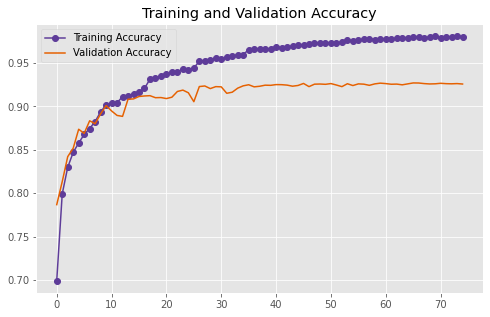

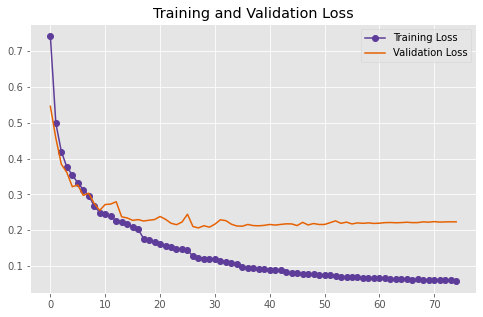

In [ ]:
plot_train_curve(history)

## Final Results for 2-Layered CNN Models

The results from the best variation of each model developed in Experiment 3 is summarized below:

|Model|Test Accuracy|Test Loss|Summary                    |
|:---:|:-----------:|:-------:|:-------------------------:|
|7    |0.896        |0.400    |Baseline 2-Layer CNN       |
|8    |0.891        |0.282    |Tuned 2nd CNN Layer        |
|9    |0.924        |0.243    |Hyperparameter Tuned Model |

Our analysis so far conveys the following: **Model 9 boasts the highest test accuracy of 0.924 and also the lowest loss among all Experiment 2 models, measuring 0.243!** 

It contains the following architecture:

- 1 Convolution Layer: 32 filters of 5x5, stride 1
- 1 Max Pooling Layer: 3x3 pool, stride 1
- 1 Convolution Layer: 32 filters of 5x5, stride 1
- 1 Max Pooling Layer: 2x2 pool, stride 2
- 1 Dense Layer: 1000 nodes, activation = ReLU 
- 1 Output Layer: 5 nodes, activation = Softmax  

It contains the following hyperparameters:
- Loss: categorical crossentropy
- Optimizer: Adam
- Learning rate: step decay ($LR_i$ = 0.001, $DR$ = 0.6, $E_D$ = 9.0)
- Kernel Initializer: he_uniform
- Batch size: 64
- Epochs: 75

We will build upon this configuration to start our final experiment, which deals with a 3-Layered CNN network!

# Experiment 4: 3-Layer CNN

This experiment will use the best configuration from Experiment 2 (ie. Model 9) and build upon it to produce the best possible 3-Layered CNN network!

## Model 10 - Baseline 3-Layer CNN

We will duplicate the 2nd convolution layer as the 3rd layer and examine how the model does - this will be our baseline 3-Layered CNN model:

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.001 
    drop = 0.6 
    epochs_drop = 9.0 
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

lrScheduler = LearningRateScheduler(step_decay)

model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(48, (7, 7), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam()
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, callbacks= lrScheduler,
                    epochs=75, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

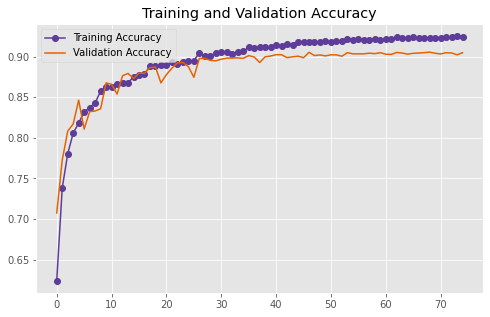

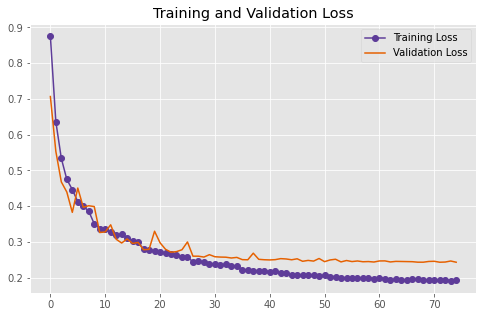

In [ ]:
plot_train_curve(history)

The baseline 3-Layered CNN Model achieves the following metrics: **test accuracy of 0.899 and a loss of 0.264**. As before, we will optimize the configuration of the 3rd convolution layer.

## Model 11 - Altering 3rd Convolution Layer



### Tuning 3rd Layer of Pooling

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import LearningRateScheduler
import math 

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

def create_model(pool_size, stride):
	# create model
  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size), strides=stride))
  model.add(Flatten())
  model.add(Dense(1000, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(5, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam()
               )	
  return model

lrScheduler = LearningRateScheduler(step_decay)

begin = time.time()

# instantiate model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [64]
epochs = [75]
pool_size = [2,3,5,7]
stride = [None,1,2]
              
param_grid = dict(batch_size=batch_size, epochs=epochs, pool_size=pool_size, stride=stride)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_data, train_label, callbacks=[lrScheduler])
  
# summarize results
print("Best: {} | Parameters: {}".format(grid_result.best_score_, grid_result.best_params_))

end = time.time()
print("\nTOTAL GRIDSEARCH TIME: {} MINUTES".format((end-begin)/60))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.9061388969421387 | Parameters: {'batch_size': 64, 'epochs': 75, 'pool_size': 2, 'stride': 1}

TOTAL GRIDSEARCH TIME: 31.577938934167225 MINUTES


GridSearchCV suggests using a pooling layer sized 2x2 with a stride of 1. Now, let's try analyzing the best convolution layer!

### Tuning 3rd Layer of Convolution

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import LearningRateScheduler
import math 

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

def create_model(numFilters, filterSize):
	# create model
  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(Conv2D(numFilters, (filterSize, filterSize), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
  model.add(Flatten())
  model.add(Dense(1000, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(5, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam()
               )	
  return model

lrScheduler = LearningRateScheduler(step_decay)

begin = time.time()

# instantiate model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [64]
epochs = [75]
numFilters = [8,16,32]
filterSize = [3,5,7]
              
param_grid = dict(batch_size=batch_size, epochs=epochs, numFilters=numFilters, filterSize=filterSize)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_data, train_label, callbacks=[lrScheduler])
  
# summarize results
print("Best: {} | Parameters: {}".format(grid_result.best_score_, grid_result.best_params_))

end = time.time()
print("\nTOTAL GRIDSEARCH TIME: {} MINUTES".format((end-begin)/60))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.9080277681350708 | Parameters: {'batch_size': 64, 'epochs': 75, 'filterSize': 3, 'numFilters': 32}

TOTAL GRIDSEARCH TIME: 32.31038889884949 MINUTES


GridSearchCV suggests using 32 filters sized 3x3. We shall now test our 3-Layered model with the optimized convolution layer.

### Testing Improved Convolution Layer

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

lrScheduler = LearningRateScheduler(step_decay)

model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam()
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, callbacks= lrScheduler,
                    epochs=75, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

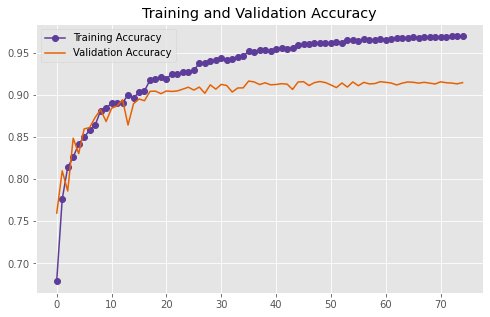

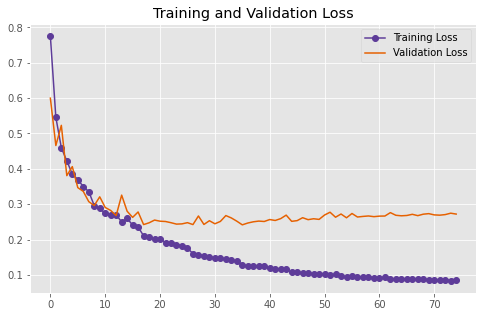

In [ ]:
plot_train_curve(history)

This model beats our baseline 3-Layered CNN Model and achieves the following metrics: **test accuracy of 0.910 and a loss of 0.281**! Finally, we shall try tuning the hyperparameters.

## Model 12 - Hyperparameter Tuning

This section is dedicated to building an improved model of Model 11 with tuned hyperparameters. We will find the optimal number of hidden units and dropout, then we will tune the step decay function, and finally we will tune the batch size and epochs. Let's get started!

### Hidden Units and Dropout

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import LearningRateScheduler
import math 

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

def create_model(units, drop):
	# create model
  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
  model.add(Flatten())
  model.add(Dense(units, activation='relu'))
  model.add(Dropout(drop))
  model.add(Dense(5, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam()
               )	
  return model

lrScheduler = LearningRateScheduler(step_decay)

begin = time.time()

# instantiate model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [64]
epochs = [75]
units = [500,750]
drop = [0.2,0.5,0.7]
              
param_grid = dict(batch_size=batch_size, epochs=epochs, units=units, drop=drop)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_data, train_label, callbacks=[lrScheduler])
  
# summarize results
print("Best: {} | Parameters: {}".format(grid_result.best_score_, grid_result.best_params_))

end = time.time()
print("\nTOTAL GRIDSEARCH TIME: {} MINUTES".format((end-begin)/60))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.9078333377838135 | Parameters: {'batch_size': 64, 'drop': 0.2, 'epochs': 75, 'units': 750}

TOTAL GRIDSEARCH TIME: 22.662572141488393 MINUTES


GridSearchCV suggests using 750 hidden units and a dropout of 0.2. We shall test this addition on the test set:

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

lrScheduler = LearningRateScheduler(step_decay)

model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(Flatten())
model.add(Dense(750, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam()
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, callbacks= lrScheduler,
                    epochs=75, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

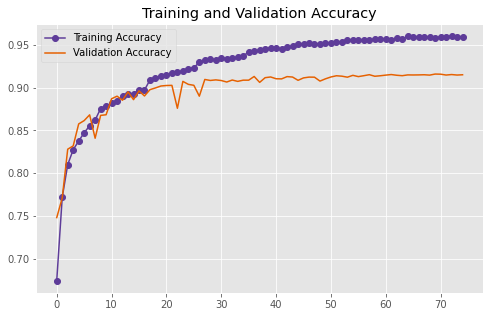

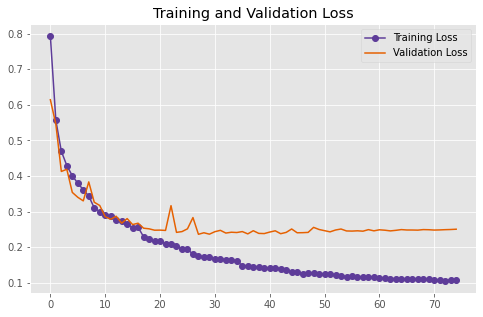

In [ ]:
plot_train_curve(history)

With the addition of a slightly larger dropout and a lower number of hidden units, the model achieves the following metrics: **Test accuracy of 0.910 and a test loss of 0.265!** This is the same accuracy as Model 11, but with a reduced loss! We shall carry this addition moving forward and tune further hyperparameters. Next, we will examine tuning the batch size and epochs!

### Tuning Step Decay, Batch Size, and Epochs

Here the different parameters of the step decay learning rate scheduler were varied along with the batch size and the epochs the model trains for. Experimentation is not shown below, but these values were converged upon through iterative testing:

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import LearningRateScheduler
import math 

def step_decay(epoch):
    initial_lrate = 0.0012
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

def create_model():
	# create model
  model = Sequential()
  model.add(Input(shape=(28,28,1)))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
  model.add(Flatten())
  model.add(Dense(750, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(5, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy',
                metrics=['acc'],
                optimizer=optimizers.Adam()
               )	
  return model

lrScheduler = LearningRateScheduler(step_decay)

begin = time.time()

# instantiate model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [16,32,64,128]
epochs = [25,50,75]
              
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_data, train_label, callbacks=[lrScheduler])
  
# summarize results
print("Best: {} | Parameters: {}".format(grid_result.best_score_, grid_result.best_params_))

end = time.time()
print("\nTOTAL GRIDSEARCH TIME: {} MINUTES".format((end-begin)/60))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.9058611194292704 | Parameters: {'batch_size': 64, 'epochs': 75}

TOTAL GRIDSEARCH TIME: 51.799858808517456 MINUTES


GridSearchCV recommends the same batch size and epochs we've been using this whole time. However, we have converged to different step decay settings. Let's test this configuration out:

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.0012
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

lrScheduler = LearningRateScheduler(step_decay)

model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(Flatten())
model.add(Dense(750, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam()
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, callbacks= lrScheduler,
                    epochs=75, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

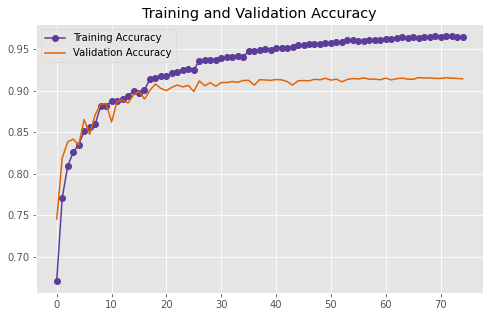

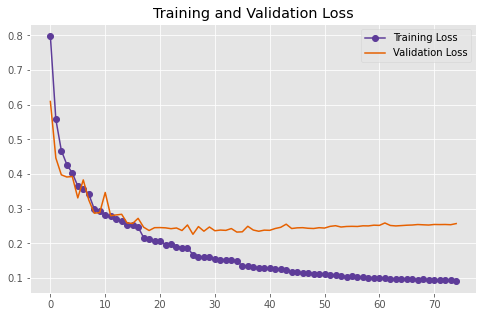

In [ ]:
plot_train_curve(history)

The model achieves the following metrics: **Test accuracy of 0.914 and a test loss of 0.273!** This is arguably the best model we have produced for 3-Layered CNN experiments! Although slightly higher in loss, the model also has the highest Experiment 3 accuracy. Looking at the loss plots above however show a very slight increase in loss from 30 epochs onward. We shall try using early stopping on this model at 30 epochs.

### Early Stopping

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.0012
    drop = 0.6
    epochs_drop = 9.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

lrScheduler = LearningRateScheduler(step_decay)

model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(Flatten())
model.add(Dense(750, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer=optimizers.Adam()
             )

# Train the model
history = model.fit(train_data, train_label,
                    validation_data = (val_data, val_label),
                    batch_size=64, callbacks= lrScheduler,
                    epochs=30, shuffle=True)

#Testing the Model
score = model.evaluate(test_data, test_label, verbose=1)
print('\nCNN Baseline Performance on Test Set:')
print('Test Accuracy = {:.3f} | Test Loss = {:.3f}'.format(score[1], score[0]))

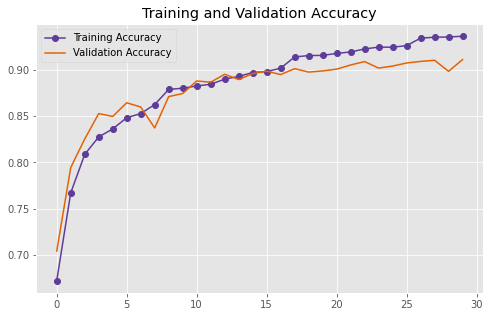

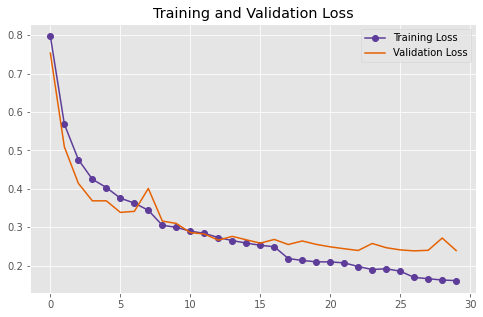

In [ ]:
plot_train_curve(history)

Using early stopping reduced the models' accuracy by a bit, but reduced the loss significantly. This model achieves the following metrics: **Test accuracy of 0.910 and a test loss of 0.248!** 